In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import tensorflow.keras
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_images_paths(path):
    data_dir = pathlib.Path(path)
    files = list(data_dir.glob('**/*.jpg'))
     
    return files

In [3]:
path = "All"
images_paths = get_images_paths(path)
data_dir = pathlib.Path(path)

In [4]:
IMG_SIZE = 300
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  shuffle=True
  )

Found 1185 files belonging to 25 classes.
Using 948 files for training.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  shuffle=True
  )

Found 1185 files belonging to 25 classes.
Using 237 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
checkpoint_path = "models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

class_names = train_dataset.class_names

In [8]:
# data_augmentation = tf.keras.Sequential(
#   [
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
#   ]
# )

# InceptionV3

In [ ]:
from keras import Model
from keras.applications import InceptionV3

num_classes = len(class_names)
epochs = 15

InceptionV3 = InceptionV3(include_top=False,
                          input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = InceptionV3.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(InceptionV3.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "InceptionV3/model")

87910968/87910968 [==============================] - 9s 0us/step
Epoch 1/15
15/15 [==============================] - 189s 12s/step - loss: 3.2641 - accuracy: 0.1941 - val_loss: 18.0233 - val_accuracy: 0.0928
Epoch 2/15
15/15 [==============================] - 178s 12s/step - loss: 1.9526 - accuracy: 0.4483 - val_loss: 11.1463 - val_accuracy: 0.1013
Epoch 3/15
15/15 [==============================] - 177s 12s/step - loss: 1.5360 - accuracy: 0.5591 - val_loss: 7.1126 - val_accuracy: 0.1603
Epoch 4/15
15/15 [==============================] - 178s 12s/step - loss: 1.1103 - accuracy: 0.6772 - val_loss: 6.2615 - val_accuracy: 0.0886
Epoch 5/15
15/15 [==============================] - 177s 12s/step - loss: 0.8087 - accuracy: 0.7627 - val_loss: 4.7440 - val_accuracy: 0.1772
Epoch 6/15
15/15 [==============================] - 178s 12s/step - loss: 0.5232 - accuracy: 0.8534 - val_loss: 3.5723 - val_accuracy: 0.2743
Epoch 7/15
15/15 [==============================] - 176s 12s/step - loss: 0.3664 

# DenseNet169

In [53]:
from keras import Model
from keras.applications.densenet import DenseNet169

num_classes = len(class_names)
epochs = 15

DenseNet169 = DenseNet169(include_top=False,
                          input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = DenseNet169.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(DenseNet169.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "DenseNet169/model")

51877672/51877672 [==============================] - 5s 0us/step
Epoch 1/15
15/15 [==============================] - 157s 10s/step - loss: 3.2917 - accuracy: 0.2173 - val_loss: 10.4035 - val_accuracy: 0.1181
Epoch 2/15
15/15 [==============================] - 143s 10s/step - loss: 1.9839 - accuracy: 0.4525 - val_loss: 4.9649 - val_accuracy: 0.1646
Epoch 3/15
15/15 [==============================] - 143s 10s/step - loss: 1.5410 - accuracy: 0.5844 - val_loss: 3.9367 - val_accuracy: 0.2194
Epoch 4/15
15/15 [==============================] - 141s 10s/step - loss: 1.0808 - accuracy: 0.7078 - val_loss: 3.0888 - val_accuracy: 0.2616
Epoch 5/15
15/15 [==============================] - 141s 10s/step - loss: 0.7840 - accuracy: 0.7964 - val_loss: 2.8616 - val_accuracy: 0.3080
Epoch 6/15
15/15 [==============================] - 143s 10s/step - loss: 0.5225 - accuracy: 0.8671 - val_loss: 2.6372 - val_accuracy: 0.3291
Epoch 7/15
15/15 [==============================] - 140s 9s/step - loss: 0.3690 - 

INFO:tensorflow:Assets written to: DenseNet169/model\assets


INFO:tensorflow:Assets written to: DenseNet169/model\assets


# DenseNet121

In [52]:
from keras import Model
from keras.applications.densenet import DenseNet121

num_classes = len(class_names)
epochs = 15

DenseNet121 = DenseNet121(include_top=False,
              input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = DenseNet121.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(DenseNet121.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "DenseNet121/model")

29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/15
15/15 [==============================] - 118s 8s/step - loss: 3.0954 - accuracy: 0.2321 - val_loss: 11.4291 - val_accuracy: 0.0591
Epoch 2/15
15/15 [==============================] - 108s 7s/step - loss: 1.6701 - accuracy: 0.5380 - val_loss: 5.2722 - val_accuracy: 0.1772
Epoch 3/15
15/15 [==============================] - 113s 8s/step - loss: 1.1528 - accuracy: 0.6772 - val_loss: 4.4698 - val_accuracy: 0.1857
Epoch 4/15
15/15 [==============================] - 113s 8s/step - loss: 0.7551 - accuracy: 0.7901 - val_loss: 3.3318 - val_accuracy: 0.2700
Epoch 5/15
15/15 [==============================] - 110s 7s/step - loss: 0.4609 - accuracy: 0.8829 - val_loss: 2.8434 - val_accuracy: 0.3165
Epoch 6/15
15/15 [==============================] - 110s 7s/step - loss: 0.2806 - accuracy: 0.9293 - val_loss: 2.4841 - val_accuracy: 0.3924
Epoch 7/15
15/15 [==============================] - 111s 7s/step - loss: 0.1970 - accura

INFO:tensorflow:Assets written to: DenseNet121/model\assets


INFO:tensorflow:Assets written to: DenseNet121/model\assets


# EfficientNetB5

In [ ]:
from keras import Model
from keras.applications.efficientnet import EfficientNetB5

num_classes = len(class_names)
epochs = 15

EfficientNetB5 = EfficientNetB5(include_top=False,
                                input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = EfficientNetB5.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(EfficientNetB5.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "EfficientNetB5/model")

Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb5_notop.h5
115269632/115263384 [==============================] - 5s 0us/step
115277824/115263384 [==============================] - 5s 0us/step
Epoch 1/15
15/15 [==============================] - 204s 13s/step - loss: 2.0813 - accuracy: 0.4852 - val_loss: 5.7276 - val_accuracy: 0.4346
Epoch 2/15
15/15 [==============================] - 172s 12s/step - loss: 0.6604 - accuracy: 0.8017 - val_loss: 3.0882 - val_accuracy: 0.5063
Epoch 3/15
15/15 [==============================] - 174s 12s/step - loss: 0.3856 - accuracy: 0.8882 - val_loss: 1.7927 - val_accuracy: 0.5738
Epoch 4/15
15/15 [==============================] - 171s 12s/step - loss: 0.2180 - accuracy: 0.9451 - val_loss: 1.4401 - val_accuracy: 0.6118
Epoch 5/15
15/15 [==============================] - 171s 11s/step - loss: 0.1488 - accuracy: 0.9694 - val_loss: 1.1409 - val_accuracy: 0.6709
Epoch 6/15
15/15 [==============================] - 173s 12s/step - loss: 0.1482 - accuracy: 0.9557 - val_loss: 1.1785 - val_accuracy: 0.6667
Epoch 7/15
15/15 [==============================] - 171s 12s/step - loss: 0.1249 - accuracy: 0.9684 - val_loss: 1.1123 - val_accuracy: 0.6920
Epoch 8/15
15/15 [==============================] - 171s 12s/step - loss: 0.1169 - accuracy: 0.9736 - val_loss: 1.0960 - val_accuracy: 0.6793
Epoch 9/15
15/15 [==============================] - 171s 12s/step - loss: 0.1219 - accuracy: 0.9726 - val_loss: 1.0940 - val_accuracy: 0.7173
Epoch 10/15
15/15 [==============================] - 172s 12s/step - loss: 0.1011 - accuracy: 0.9736 - val_loss: 1.0477 - val_accuracy: 0.6962
Epoch 11/15
15/15 [==============================] - 174s 12s/step - loss: 0.0970 - accuracy: 0.9800 - val_loss: 1.0116 - val_accuracy: 0.6793
Epoch 12/15
15/15 [==============================] - 171s 12s/step - loss: 0.0932 - accuracy: 0.9778 - val_loss: 1.0052 - val_accuracy: 0.6878
Epoch 13/15
15/15 [==============================] - 177s 12s/step - loss: 0.0799 - accuracy: 0.9789 - val_loss: 1.0542 - val_accuracy: 0.7004
Epoch 14/15
15/15 [==============================] - 174s 12s/step - loss: 0.0476 - accuracy: 0.9863 - val_loss: 1.1134 - val_accuracy: 0.6920
Epoch 15/15
15/15 [==============================] - 172s 12s/step - loss: 0.0875 - accuracy: 0.9789 - val_loss: 1.0156 - val_accuracy: 0.7004

# EfficientNetB4

In [ ]:
from keras import Model
from keras.applications.efficientnet import EfficientNetB4

num_classes = len(class_names)
epochs = 15

EfficientNetB4 = EfficientNetB4(include_top=False,
                                input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = EfficientNetB4.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(EfficientNetB4.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "EfficientNetB4/model")

Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb4_notop.h5
71688192/71686520 [==============================] - 3s 0us/step
71696384/71686520 [==============================] - 3s 0us/step
Epoch 1/15
15/15 [==============================] - 140s 9s/step - loss: 2.1180 - accuracy: 0.4747 - val_loss: 6.9196 - val_accuracy: 0.4177
Epoch 2/15
15/15 [==============================] - 120s 8s/step - loss: 0.6276 - accuracy: 0.8207 - val_loss: 2.8773 - val_accuracy: 0.5401
Epoch 3/15
15/15 [==============================] - 121s 8s/step - loss: 0.3557 - accuracy: 0.9061 - val_loss: 2.1539 - val_accuracy: 0.5823
Epoch 4/15
15/15 [==============================] - 121s 8s/step - loss: 0.1937 - accuracy: 0.9515 - val_loss: 1.7844 - val_accuracy: 0.5865
Epoch 5/15
15/15 [==============================] - 118s 8s/step - loss: 0.1545 - accuracy: 0.9652 - val_loss: 1.4924 - val_accuracy: 0.6456
Epoch 6/15
15/15 [==============================] - 119s 8s/step - loss: 0.1453 - accuracy: 0.9684 - val_loss: 1.4385 - val_accuracy: 0.6287
Epoch 7/15
15/15 [==============================] - 118s 8s/step - loss: 0.1063 - accuracy: 0.9768 - val_loss: 1.3609 - val_accuracy: 0.6540
Epoch 8/15
15/15 [==============================] - 120s 8s/step - loss: 0.1068 - accuracy: 0.9705 - val_loss: 1.2786 - val_accuracy: 0.6540
Epoch 9/15
15/15 [==============================] - 118s 8s/step - loss: 0.0743 - accuracy: 0.9789 - val_loss: 1.2579 - val_accuracy: 0.6540
Epoch 10/15
15/15 [==============================] - 118s 8s/step - loss: 0.0907 - accuracy: 0.9768 - val_loss: 1.2830 - val_accuracy: 0.6667
Epoch 11/15
15/15 [==============================] - 121s 8s/step - loss: 0.0980 - accuracy: 0.9789 - val_loss: 1.2591 - val_accuracy: 0.6835
Epoch 12/15
15/15 [==============================] - 119s 8s/step - loss: 0.0929 - accuracy: 0.9810 - val_loss: 1.2674 - val_accuracy: 0.6709
Epoch 13/15
15/15 [==============================] - 118s 8s/step - loss: 0.0675 - accuracy: 0.9842 - val_loss: 1.2464 - val_accuracy: 0.6835
Epoch 14/15
15/15 [==============================] - 118s 8s/step - loss: 0.0681 - accuracy: 0.9831 - val_loss: 1.3334 - val_accuracy: 0.6751
Epoch 15/15
15/15 [==============================] - 119s 8s/step - loss: 0.0825 - accuracy: 0.9800 - val_loss: 1.2461 - val_accuracy: 0.6793

# EfficientNetB2

In [ ]:
from keras import Model
from keras.applications.efficientnet import EfficientNetB2

num_classes = len(class_names)
epochs = 15

EfficientNetB2 = EfficientNetB2(include_top=False,
                                input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = EfficientNetB2.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(EfficientNetB2.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "EfficientNetB2/model")

Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb2_notop.h5
31793152/31790344 [==============================] - 2s 0us/step
31801344/31790344 [==============================] - 2s 0us/step
Epoch 1/15
15/15 [==============================] - 77s 4s/step - loss: 2.0235 - accuracy: 0.4947 - val_loss: 3.1055 - val_accuracy: 0.5401
Epoch 2/15
15/15 [==============================] - 62s 4s/step - loss: 0.5072 - accuracy: 0.8534 - val_loss: 1.7877 - val_accuracy: 0.5654
Epoch 3/15
15/15 [==============================] - 63s 4s/step - loss: 0.2477 - accuracy: 0.9388 - val_loss: 1.5742 - val_accuracy: 0.5865
Epoch 4/15
15/15 [==============================] - 64s 4s/step - loss: 0.1607 - accuracy: 0.9610 - val_loss: 1.3279 - val_accuracy: 0.6456
Epoch 5/15
15/15 [==============================] - 63s 4s/step - loss: 0.1273 - accuracy: 0.9715 - val_loss: 1.1809 - val_accuracy: 0.6582
Epoch 6/15
15/15 [==============================] - 64s 4s/step - loss: 0.1059 - accuracy: 0.9757 - val_loss: 1.1252 - val_accuracy: 0.6793
Epoch 7/15
15/15 [==============================] - 63s 4s/step - loss: 0.0881 - accuracy: 0.9810 - val_loss: 1.0733 - val_accuracy: 0.6920
Epoch 8/15
15/15 [==============================] - 62s 4s/step - loss: 0.1002 - accuracy: 0.9726 - val_loss: 1.0567 - val_accuracy: 0.7004
Epoch 9/15
15/15 [==============================] - 62s 4s/step - loss: 0.0808 - accuracy: 0.9810 - val_loss: 1.0096 - val_accuracy: 0.6962
Epoch 10/15
15/15 [==============================] - 62s 4s/step - loss: 0.0723 - accuracy: 0.9852 - val_loss: 1.0468 - val_accuracy: 0.7046
Epoch 11/15
15/15 [==============================] - 62s 4s/step - loss: 0.1015 - accuracy: 0.9800 - val_loss: 1.0617 - val_accuracy: 0.7004
Epoch 12/15
15/15 [==============================] - 62s 4s/step - loss: 0.0649 - accuracy: 0.9863 - val_loss: 1.0267 - val_accuracy: 0.7046
Epoch 13/15
15/15 [==============================] - 62s 4s/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 1.0379 - val_accuracy: 0.7215
Epoch 14/15
15/15 [==============================] - 63s 4s/step - loss: 0.0668 - accuracy: 0.9810 - val_loss: 1.0067 - val_accuracy: 0.7173
Epoch 15/15
15/15 [==============================] - 62s 4s/step - loss: 0.0590 - accuracy: 0.9863 - val_loss: 1.0641 - val_accuracy: 0.7173

# EfficientNetB1

In [ ]:
from keras import Model
from keras.applications.efficientnet import EfficientNetB1

num_classes = len(class_names)
epochs = 15

EfficientNetB1 = EfficientNetB1(include_top=False,
                                input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = EfficientNetB1.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(EfficientNetB1.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "EfficientNetB1/model")

Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb1_notop.h5
27025408/27018416 [==============================] - 2s 0us/step
27033600/27018416 [==============================] - 2s 0us/step
Epoch 1/15
15/15 [==============================] - 70s 4s/step - loss: 2.0343 - accuracy: 0.4789 - val_loss: 3.1447 - val_accuracy: 0.5823
Epoch 2/15
15/15 [==============================] - 58s 4s/step - loss: 0.3957 - accuracy: 0.8987 - val_loss: 2.1919 - val_accuracy: 0.5949
Epoch 3/15
15/15 [==============================] - 57s 4s/step - loss: 0.2029 - accuracy: 0.9568 - val_loss: 1.7179 - val_accuracy: 0.6160
Epoch 4/15
15/15 [==============================] - 57s 4s/step - loss: 0.1377 - accuracy: 0.9768 - val_loss: 1.3990 - val_accuracy: 0.6582
Epoch 5/15
15/15 [==============================] - 58s 4s/step - loss: 0.0989 - accuracy: 0.9768 - val_loss: 1.3017 - val_accuracy: 0.6793
Epoch 6/15
15/15 [==============================] - 57s 4s/step - loss: 0.0763 - accuracy: 0.9821 - val_loss: 1.2581 - val_accuracy: 0.6751
Epoch 7/15
15/15 [==============================] - 57s 4s/step - loss: 0.0803 - accuracy: 0.9789 - val_loss: 1.2266 - val_accuracy: 0.6835
Epoch 8/15
15/15 [==============================] - 57s 4s/step - loss: 0.0798 - accuracy: 0.9800 - val_loss: 1.1588 - val_accuracy: 0.6878
Epoch 9/15
15/15 [==============================] - 57s 4s/step - loss: 0.0843 - accuracy: 0.9810 - val_loss: 1.1786 - val_accuracy: 0.6878
Epoch 10/15
15/15 [==============================] - 57s 4s/step - loss: 0.0756 - accuracy: 0.9831 - val_loss: 1.1710 - val_accuracy: 0.7004
Epoch 11/15
15/15 [==============================] - 57s 4s/step - loss: 0.0772 - accuracy: 0.9831 - val_loss: 1.1552 - val_accuracy: 0.7046
Epoch 12/15
15/15 [==============================] - 57s 4s/step - loss: 0.0669 - accuracy: 0.9842 - val_loss: 1.1130 - val_accuracy: 0.7089
Epoch 13/15
15/15 [==============================] - 57s 4s/step - loss: 0.0578 - accuracy: 0.9831 - val_loss: 1.1296 - val_accuracy: 0.6962
Epoch 14/15
15/15 [==============================] - 57s 4s/step - loss: 0.0773 - accuracy: 0.9852 - val_loss: 1.1661 - val_accuracy: 0.6920
Epoch 15/15
15/15 [==============================] - 56s 4s/step - loss: 0.0624 - accuracy: 0.9821 - val_loss: 1.1652 - val_accuracy: 0.6835

# EfficientNetB0

In [ ]:
from keras import Model
from keras.applications.efficientnet import EfficientNetB0

num_classes = len(class_names)
epochs = 15

EfficientNetB0   = EfficientNetB0 (include_top=False,
                                   input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = EfficientNetB0 .get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(EfficientNetB0 .input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "EfficientNetB0 /model")

Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5
16711680/16705208 [==============================] - 1s 0us/step
16719872/16705208 [==============================] - 1s 0us/step
Epoch 1/15
15/15 [==============================] - 54s 3s/step - loss: 1.9845 - accuracy: 0.4884 - val_loss: 3.4257 - val_accuracy: 0.5274
Epoch 2/15
15/15 [==============================] - 44s 3s/step - loss: 0.4359 - accuracy: 0.8861 - val_loss: 2.1484 - val_accuracy: 0.5949
Epoch 3/15
15/15 [==============================] - 43s 3s/step - loss: 0.2216 - accuracy: 0.9473 - val_loss: 1.8181 - val_accuracy: 0.6371
Epoch 4/15
15/15 [==============================] - 43s 3s/step - loss: 0.1169 - accuracy: 0.9684 - val_loss: 1.5994 - val_accuracy: 0.6329
Epoch 5/15
15/15 [==============================] - 44s 3s/step - loss: 0.1046 - accuracy: 0.9778 - val_loss: 1.4666 - val_accuracy: 0.6624
Epoch 6/15
15/15 [==============================] - 43s 3s/step - loss: 0.0944 - accuracy: 0.9768 - val_loss: 1.3277 - val_accuracy: 0.6835
Epoch 7/15
15/15 [==============================] - 44s 3s/step - loss: 0.0870 - accuracy: 0.9831 - val_loss: 1.2863 - val_accuracy: 0.6878
Epoch 8/15
15/15 [==============================] - 43s 3s/step - loss: 0.0773 - accuracy: 0.9768 - val_loss: 1.2176 - val_accuracy: 0.6878
Epoch 9/15
15/15 [==============================] - 43s 3s/step - loss: 0.0876 - accuracy: 0.9768 - val_loss: 1.1917 - val_accuracy: 0.7046
Epoch 10/15
15/15 [==============================] - 44s 3s/step - loss: 0.0729 - accuracy: 0.9863 - val_loss: 1.2214 - val_accuracy: 0.6878
Epoch 11/15
15/15 [==============================] - 43s 3s/step - loss: 0.0886 - accuracy: 0.9768 - val_loss: 1.1895 - val_accuracy: 0.6962
Epoch 12/15
15/15 [==============================] - 43s 3s/step - loss: 0.0662 - accuracy: 0.9800 - val_loss: 1.1591 - val_accuracy: 0.7004
Epoch 13/15
15/15 [==============================] - 43s 3s/step - loss: 0.0833 - accuracy: 0.9821 - val_loss: 1.1284 - val_accuracy: 0.6962
Epoch 14/15
15/15 [==============================] - 43s 3s/step - loss: 0.0801 - accuracy: 0.9831 - val_loss: 1.1882 - val_accuracy: 0.6920
Epoch 15/15
15/15 [==============================] - 43s 3s/step - loss: 0.0854 - accuracy: 0.9842 - val_loss: 1.1290 - val_accuracy: 0.6920

# VGG16

In [ ]:
from keras import Model
from keras.applications.vgg16 import VGG16

num_classes = len(class_names)
epochs = 15

VGG16  = VGG16(include_top=False,
               input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = VGG16.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(VGG16.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "VGG16/model")

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
58892288/58889256 [==============================] - 3s 0us/step
58900480/58889256 [==============================] - 3s 0us/step
Epoch 1/15
2022-12-15 12:24:52.166911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
15/15 [==============================] - 569s 38s/step - loss: 2.2551 - accuracy: 0.4451 - val_loss: 5.8146 - val_accuracy: 0.4304
Epoch 2/15
15/15 [==============================] - 562s 38s/step - loss: 0.3498 - accuracy: 0.9188 - val_loss: 3.1090 - val_accuracy: 0.4684
Epoch 3/15
15/15 [==============================] - 568s 38s/step - loss: 0.1572 - accuracy: 0.9726 - val_loss: 2.0240 - val_accuracy: 0.5696
Epoch 4/15
15/15 [==============================] - 558s 38s/step - loss: 0.0898 - accuracy: 0.9778 - val_loss: 1.7609 - val_accuracy: 0.6034
Epoch 5/15
15/15 [==============================] - 568s 38s/step - loss: 0.0794 - accuracy: 0.9810 - val_loss: 1.5039 - val_accuracy: 0.6245
Epoch 6/15
15/15 [==============================] - 565s 38s/step - loss: 0.0821 - accuracy: 0.9821 - val_loss: 1.3741 - val_accuracy: 0.6498
Epoch 7/15
15/15 [==============================] - 561s 38s/step - loss: 0.0741 - accuracy: 0.9842 - val_loss: 1.3785 - val_accuracy: 0.6498
Epoch 8/15
15/15 [==============================] - 562s 38s/step - loss: 0.0793 - accuracy: 0.9789 - val_loss: 1.3396 - val_accuracy: 0.6498
Epoch 9/15
15/15 [==============================] - 560s 38s/step - loss: 0.0666 - accuracy: 0.9852 - val_loss: 1.2644 - val_accuracy: 0.6540
Epoch 10/15
15/15 [==============================] - 566s 38s/step - loss: 0.0611 - accuracy: 0.9852 - val_loss: 1.2459 - val_accuracy: 0.6582
Epoch 11/15
15/15 [==============================] - 570s 38s/step - loss: 0.0572 - accuracy: 0.9821 - val_loss: 1.2812 - val_accuracy: 0.6498
Epoch 12/15
15/15 [==============================] - 564s 38s/step - loss: 0.0559 - accuracy: 0.9821 - val_loss: 1.2759 - val_accuracy: 0.6540
Epoch 13/15
15/15 [==============================] - 567s 38s/step - loss: 0.0670 - accuracy: 0.9842 - val_loss: 1.2822 - val_accuracy: 0.6582
Epoch 14/15
15/15 [==============================] - 565s 38s/step - loss: 0.0809 - accuracy: 0.9810 - val_loss: 1.2861 - val_accuracy: 0.6329
Epoch 15/15
15/15 [==============================] - 561s 38s/step - loss: 0.0705 - accuracy: 0.9842 - val_loss: 1.2873 - val_accuracy: 0.6540

# ResNet 152

In [ ]:
from keras import Model
from keras.applications import ResNet152

num_classes = len(class_names)
epochs = 15

ResNet152  = ResNet152(include_top=False,
                       input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = ResNet152.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(ResNet152.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "ResNet152/model")

output:

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5
234698864/234698864 [==============================] - 2s 0us/step
Epoch 1/15
15/15 [==============================] - 968s 64s/step - loss: 2.1393 - accuracy: 0.4736 - val_loss: 5.0950 - val_accuracy: 0.4219
Epoch 2/15
15/15 [==============================] - 965s 65s/step - loss: 0.3719 - accuracy: 0.9188 - val_loss: 3.2473 - val_accuracy: 0.4430
Epoch 3/15
15/15 [==============================] - 960s 65s/step - loss: 0.1650 - accuracy: 0.9684 - val_loss: 2.6873 - val_accuracy: 0.4599
Epoch 4/15
15/15 [==============================] - 1034s 70s/step - loss: 0.1097 - accuracy: 0.9789 - val_loss: 2.0203 - val_accuracy: 0.5316
Epoch 5/15
15/15 [==============================] - 984s 66s/step - loss: 0.0919 - accuracy: 0.9789 - val_loss: 1.7731 - val_accuracy: 0.5696
Epoch 6/15
15/15 [==============================] - 958s 65s/step - loss: 0.0808 - accuracy: 0.9800 - val_loss: 1.5625 - val_accuracy: 0.6076
Epoch 7/15
15/15 [==============================] - 954s 64s/step - loss: 0.0755 - accuracy: 0.9831 - val_loss: 1.4304 - val_accuracy: 0.6203
Epoch 8/15
15/15 [==============================] - 983s 66s/step - loss: 0.0705 - accuracy: 0.9810 - val_loss: 1.3699 - val_accuracy: 0.6287
Epoch 9/15
15/15 [==============================] - 970s 66s/step - loss: 0.0640 - accuracy: 0.9831 - val_loss: 1.2901 - val_accuracy: 0.6582
Epoch 10/15
15/15 [==============================] - 978s 66s/step - loss: 0.0519 - accuracy: 0.9895 - val_loss: 1.2813 - val_accuracy: 0.6582
Epoch 11/15
15/15 [==============================] - 983s 66s/step - loss: 0.0479 - accuracy: 0.9884 - val_loss: 1.2521 - val_accuracy: 0.6667
Epoch 12/15
15/15 [==============================] - 971s 66s/step - loss: 0.0429 - accuracy: 0.9905 - val_loss: 1.2303 - val_accuracy: 0.6709
Epoch 13/15
15/15 [==============================] - 978s 66s/step - loss: 0.0586 - accuracy: 0.9842 - val_loss: 1.2109 - val_accuracy: 0.6667
Epoch 14/15
15/15 [==============================] - 956s 65s/step - loss: 0.0858 - accuracy: 0.9789 - val_loss: 1.2342 - val_accuracy: 0.6624
Epoch 15/15
15/15 [==============================] - 983s 66s/step - loss: 0.0626 - accuracy: 0.9873 - val_loss: 1.2231 - val_accuracy: 0.6751
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 155). These functions will not be directly callable after loading.

# VGG19

In [9]:
from keras import Model
from keras.applications.vgg19 import VGG19

num_classes = len(class_names)
epochs = 15

vgg19 = VGG19(include_top=False,
                         input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = vgg19.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(vgg19.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "VGG19/model")

Epoch 1/15
15/15 [==============================] - 230s 15s/step - loss: 2.2959 - accuracy: 0.4335 - val_loss: 6.8021 - val_accuracy: 0.2785
Epoch 2/15
15/15 [==============================] - 229s 15s/step - loss: 0.3762 - accuracy: 0.9219 - val_loss: 3.0872 - val_accuracy: 0.4135
Epoch 3/15
15/15 [==============================] - 230s 16s/step - loss: 0.1555 - accuracy: 0.9684 - val_loss: 2.3148 - val_accuracy: 0.5105
Epoch 4/15
15/15 [==============================] - 226s 15s/step - loss: 0.1199 - accuracy: 0.9726 - val_loss: 1.8028 - val_accuracy: 0.5781
Epoch 5/15
15/15 [==============================] - 228s 15s/step - loss: 0.0899 - accuracy: 0.9821 - val_loss: 1.6240 - val_accuracy: 0.5907
Epoch 6/15
15/15 [==============================] - 226s 15s/step - loss: 0.0704 - accuracy: 0.9800 - val_loss: 1.4814 - val_accuracy: 0.6160
Epoch 7/15
15/15 [==============================] - 236s 16s/step - loss: 0.0505 - accuracy: 0.9831 - val_loss: 1.4330 - val_accuracy: 0.6329
Epoch 

INFO:tensorflow:Assets written to: VGG19/model\assets


INFO:tensorflow:Assets written to: VGG19/model\assets


21102020 internet

# ResNet50

In [33]:
from keras import Model
from keras.applications import ResNet50

num_classes = len(class_names)
epochs = 15

resnet50_base = ResNet50(include_top=False,
                         input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = resnet50_base.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(resnet50_base.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "ResNet50/model")

94765736/94765736 [==============================] - 10s 0us/step
Epoch 1/15
15/15 [==============================] - 105s 7s/step - loss: 2.1789 - accuracy: 0.4462 - val_loss: 9.2301 - val_accuracy: 0.3080
Epoch 2/15
15/15 [==============================] - 104s 7s/step - loss: 0.4038 - accuracy: 0.9030 - val_loss: 3.8605 - val_accuracy: 0.4177
Epoch 3/15
15/15 [==============================] - 118s 8s/step - loss: 0.1707 - accuracy: 0.9684 - val_loss: 2.2280 - val_accuracy: 0.5021
Epoch 4/15
15/15 [==============================] - 115s 8s/step - loss: 0.1105 - accuracy: 0.9821 - val_loss: 1.7230 - val_accuracy: 0.5485
Epoch 5/15
15/15 [==============================] - 109s 7s/step - loss: 0.1035 - accuracy: 0.9800 - val_loss: 1.5689 - val_accuracy: 0.5865
Epoch 6/15
15/15 [==============================] - 106s 7s/step - loss: 0.0788 - accuracy: 0.9842 - val_loss: 1.4090 - val_accuracy: 0.6245
Epoch 7/15
15/15 [==============================] - 108s 7s/step - loss: 0.0810 - accura

INFO:tensorflow:Assets written to: training_1/model\assets


INFO:tensorflow:Assets written to: training_1/model\assets


In [27]:
# num_classes = len(class_names)
# epochs = 100
# model = tf.keras.Sequential([
#     data_augmentation,
#     tf.keras.layers.Normalization(),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),
#
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.25),
#
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.25),
#
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])
#
# model.compile(
#   optimizer='adam',
#   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])
#
#
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
#
# history = model.fit(
#   train_dataset,
#   validation_data=validation_dataset,
#   epochs=epochs,
#   callbacks=[cp_callback],
#   workers=4
# )
# saved_model = tf.keras.models.save_model(model, "models/model")

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 4.0496 - accuracy: 0.1414
Epoch 1: saving model to models\cp.ckpt
15/15 [==============================] - 107s 7s/step - loss: 4.0496 - accuracy: 0.1414 - val_loss: 19.7244 - val_accuracy: 0.0844
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 3.0606 - accuracy: 0.2184
Epoch 2: saving model to models\cp.ckpt
15/15 [==============================] - 101s 7s/step - loss: 3.0606 - accuracy: 0.2184 - val_loss: 12.3179 - val_accuracy: 0.0675
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 2.6152 - accuracy: 0.3070
Epoch 3: saving model to models\cp.ckpt
15/15 [==============================] - 99s 7s/step - loss: 2.6152 - accuracy: 0.3070 - val_loss: 9.0436 - val_accuracy: 0.0886
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 2.4109 - accuracy: 0.3713
Epoch 4: saving model to models\cp.ckpt
15/15 [==============================] - 98s 7s/step - loss: 2.4109 -

INFO:tensorflow:Assets written to: models/model\assets


INFO:tensorflow:Assets written to: models/model\assets


# EfficientNetB7

In [ ]:
from keras import Model
from keras.applications.efficientnet import EfficientNetB7

num_classes = len(class_names)
epochs = 15

EfficientNetB7 = EfficientNetB7(include_top=False,
                                input_tensor=None, input_shape=(IMG_SIZE, IMG_SIZE,3))

output = EfficientNetB7.get_layer(index = -1).output
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(512,activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)

model = Model(EfficientNetB7.input, output)
for layer in model.layers[:-7]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)
saved_model = tf.keras.models.save_model(model, "EfficientNetB7/model")

Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb7_notop.h5
258080768/258076736 [==============================] - 8s 0us/step
258088960/258076736 [==============================] - 8s 0us/step
Epoch 1/15
2022-12-16 07:40:46.924893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
15/15 [==============================] - 339s 21s/step - loss: 2.2048 - accuracy: 0.4409 - val_loss: 7.4446 - val_accuracy: 0.1730
Epoch 2/15
15/15 [==============================] - 308s 21s/step - loss: 0.8342 - accuracy: 0.7426 - val_loss: 3.8674 - val_accuracy: 0.3924
Epoch 3/15
15/15 [==============================] - 303s 20s/step - loss: 0.4927 - accuracy: 0.8639 - val_loss: 2.1124 - val_accuracy: 0.5316
Epoch 4/15
15/15 [==============================] - 300s 20s/step - loss: 0.2858 - accuracy: 0.9241 - val_loss: 1.6935 - val_accuracy: 0.5781
Epoch 5/15
15/15 [==============================] - 300s 20s/step - loss: 0.2324 - accuracy: 0.9388 - val_loss: 1.4843 - val_accuracy: 0.6118
Epoch 6/15
15/15 [==============================] - 302s 20s/step - loss: 0.1767 - accuracy: 0.9557 - val_loss: 1.2286 - val_accuracy: 0.6414
Epoch 7/15
15/15 [==============================] - 312s 21s/step - loss: 0.1599 - accuracy: 0.9631 - val_loss: 1.2945 - val_accuracy: 0.6414
Epoch 8/15
15/15 [==============================] - 299s 20s/step - loss: 0.1095 - accuracy: 0.9778 - val_loss: 1.1810 - val_accuracy: 0.6878
Epoch 9/15
15/15 [==============================] - 299s 20s/step - loss: 0.1371 - accuracy: 0.9705 - val_loss: 1.2065 - val_accuracy: 0.6751
Epoch 10/15
15/15 [==============================] - 300s 20s/step - loss: 0.1165 - accuracy: 0.9705 - val_loss: 1.1795 - val_accuracy: 0.7004
Epoch 11/15
15/15 [==============================] - 301s 20s/step - loss: 0.0971 - accuracy: 0.9778 - val_loss: 1.1426 - val_accuracy: 0.7131
Epoch 12/15
15/15 [==============================] - 301s 20s/step - loss: 0.0877 - accuracy: 0.9789 - val_loss: 1.1914 - val_accuracy: 0.6920
Epoch 13/15
15/15 [==============================] - 301s 20s/step - loss: 0.0729 - accuracy: 0.9789 - val_loss: 1.1759 - val_accuracy: 0.6920
Epoch 14/15
15/15 [==============================] - 299s 20s/step - loss: 0.0936 - accuracy: 0.9789 - val_loss: 1.1038 - val_accuracy: 0.7046
Epoch 15/15
15/15 [==============================] - 300s 20s/step - loss: 0.0744 - accuracy: 0.9821 - val_loss: 1.0957 - val_accuracy: 0.7215

In [10]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [11]:
def predict(img_path, model):
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    return model.predict(img_array)

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                color=color))

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

1/1 [==============================] - 0s 425ms/step
1


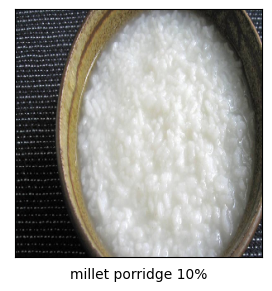

In [51]:
from PIL import Image
from random import randrange
from matplotlib import image as mpimg
loaded_model = tensorflow.keras.models.load_model("VGG19/model")

probability_model = tf.keras.Sequential([loaded_model,
                                         tf.keras.layers.Softmax()])

predictions = []
predicted_images = []
# path = images_paths[randrange(0,len(images_paths))]
path = 'test1/res1/re11/re1/3.jpg'
img = tf.keras.utils.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE))
predicted_images.append(img)
predictions.append(predict(path, probability_model))

i = randrange(0,len(predictions))
print(len(predictions))
plt.figure(figsize=(30,15))
plt.subplot(1,8,1)
plot_image(i, predictions[i], class_names, predicted_images)